# 루브릭

## 아래의 기준을 바탕으로 프로젝트를 평가합니다.

## 평가문항
상세기준

### 1. 캐글 데이터분석 전과정이 성공적으로 진행되었는가?

데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 진행되었다.

### 2. 전처리, 학습과정 및 결과에 대한 설명이 시각화를 포함하여 체계적으로 진행되었는가?

제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었다.

### 3. 회귀모델 예측정확도가 기준 이상 높게 나왔는가?

다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었다.

##  1. 베이스라인 세팅하기           



In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [41]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score

#모델 임포트
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

print("사용할 모델 임포트 완료!")

사용할 모델 임포트 완료!


In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
#데이터를 가져옵니다.
file_path = "/content/drive/MyDrive/Colab Notebooks/data"

train_path = join(file_path, 'train.csv')
test_path = join(file_path, 'test.csv')

print("트레인 패스는 여기에 :" , train_path)
print("테스트 패스는 여기에 : ", test_path)

트레인 패스는 여기에 : /content/drive/MyDrive/Colab Notebooks/data/train.csv
테스트 패스는 여기에 :  /content/drive/MyDrive/Colab Notebooks/data/test.csv


#데이터에 대해 이해하기


In [44]:
# 집 데이터 = data, 테스트셋 = sub
data = pd.read_csv(train_path)
sub = pd.read_csv(test_path)

In [45]:
#데이터와 테스트셋 크기 출력
#테스트 데이터에는 우리가 맞춰야 할 price가 없으므로 컬럼이 하나 적다(21->20)
print(data.shape)
print(sub.shape)

(15035, 21)
(6468, 20)


In [46]:
y = data['price']
del data['price']

print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


#### 학습 데이터와 테스트 데이터 합치기         

- 전체 데이터에 대해 탐색하기 위해 train과 test를 pd.concat 명령으로 합침   
- 모델 학습을 진행할 때는 이 두 데이터셋을 다시 분리해야 하므로 데이터의 개수를 따로 저장하여 기억함   

In [47]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

# data+sub = 21,503개의 데이터
print(len(data))

21503


In [48]:
#데이터를 출력해본다.

data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


#### 데이터 전처리하기        

1. missingno 라이브러리

In [49]:
#데이터의 colums을 보두 돌며 확인
for c in data.columns:
    print('{}:{}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id:0
date:0
bedrooms:0
bathrooms:0
sqft_living:0
sqft_lot:0
floors:0
waterfront:0
view:0
condition:0
grade:0
sqft_above:0
sqft_basement:0
yr_built:0
yr_renovated:0
zipcode:0
lat:0
long:0
sqft_living15:0
sqft_lot15:0


In [50]:
sub_id = data['id'][train_len:]
del data['id']

In [51]:
print(data.columns)

data.head()

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [52]:
data['date'] = data['date'].apply(lambda x : str(x[:6]))

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


---
각 변수들의 분포 확인                 

- 목적 : 전체 데이터들의 분호를 확인한다.
- 특히, 너무 치우친 분포를 가지는 컬럼의 경우 모델이 결과를 예측하는 데 좋지 않은 영향을 미치므로 다듬기

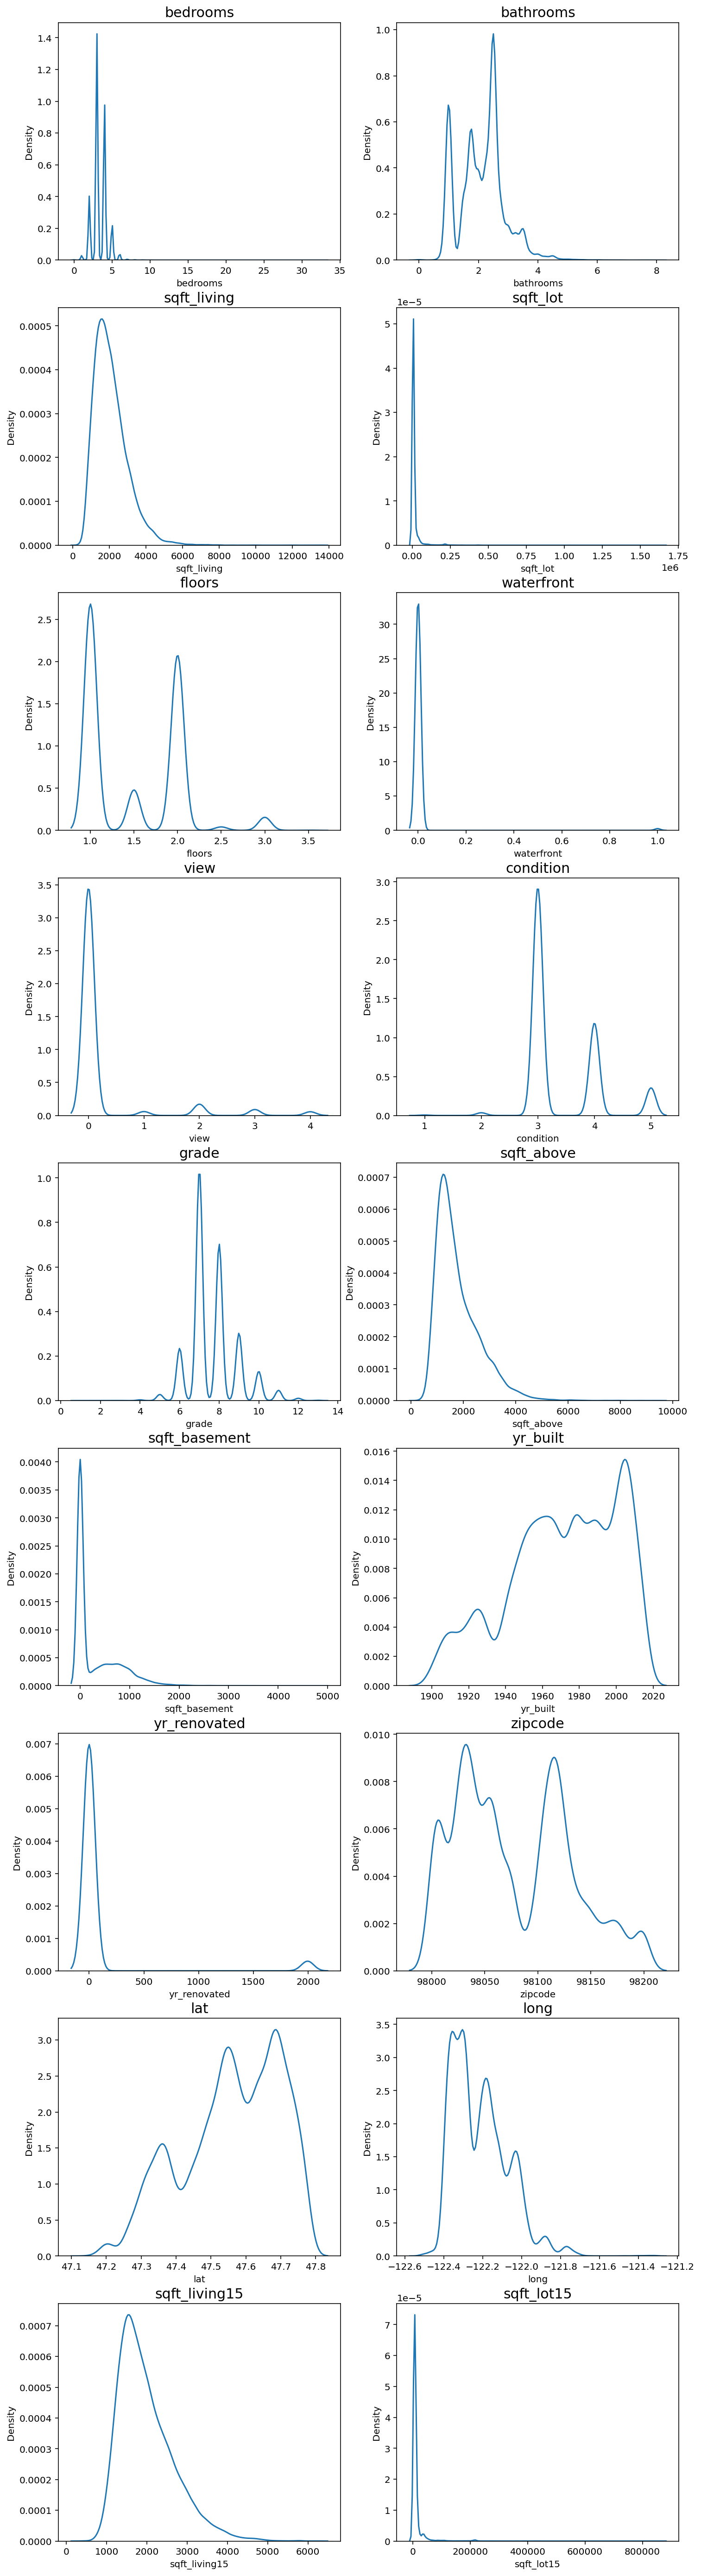

In [53]:
fig,ax = plt.subplots(9,2,figsize=(12,50))

#id 변수를 제외하고 분포 확인
count = 1
columns = data.columns

for row in range(9):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        
        count +=1
        #0번째 id열을 제외한 1열부터 19열까지 그래프를 그림.
        if count == 19:
            break

In [54]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)
    
print("변환 완료!")

변환 완료!


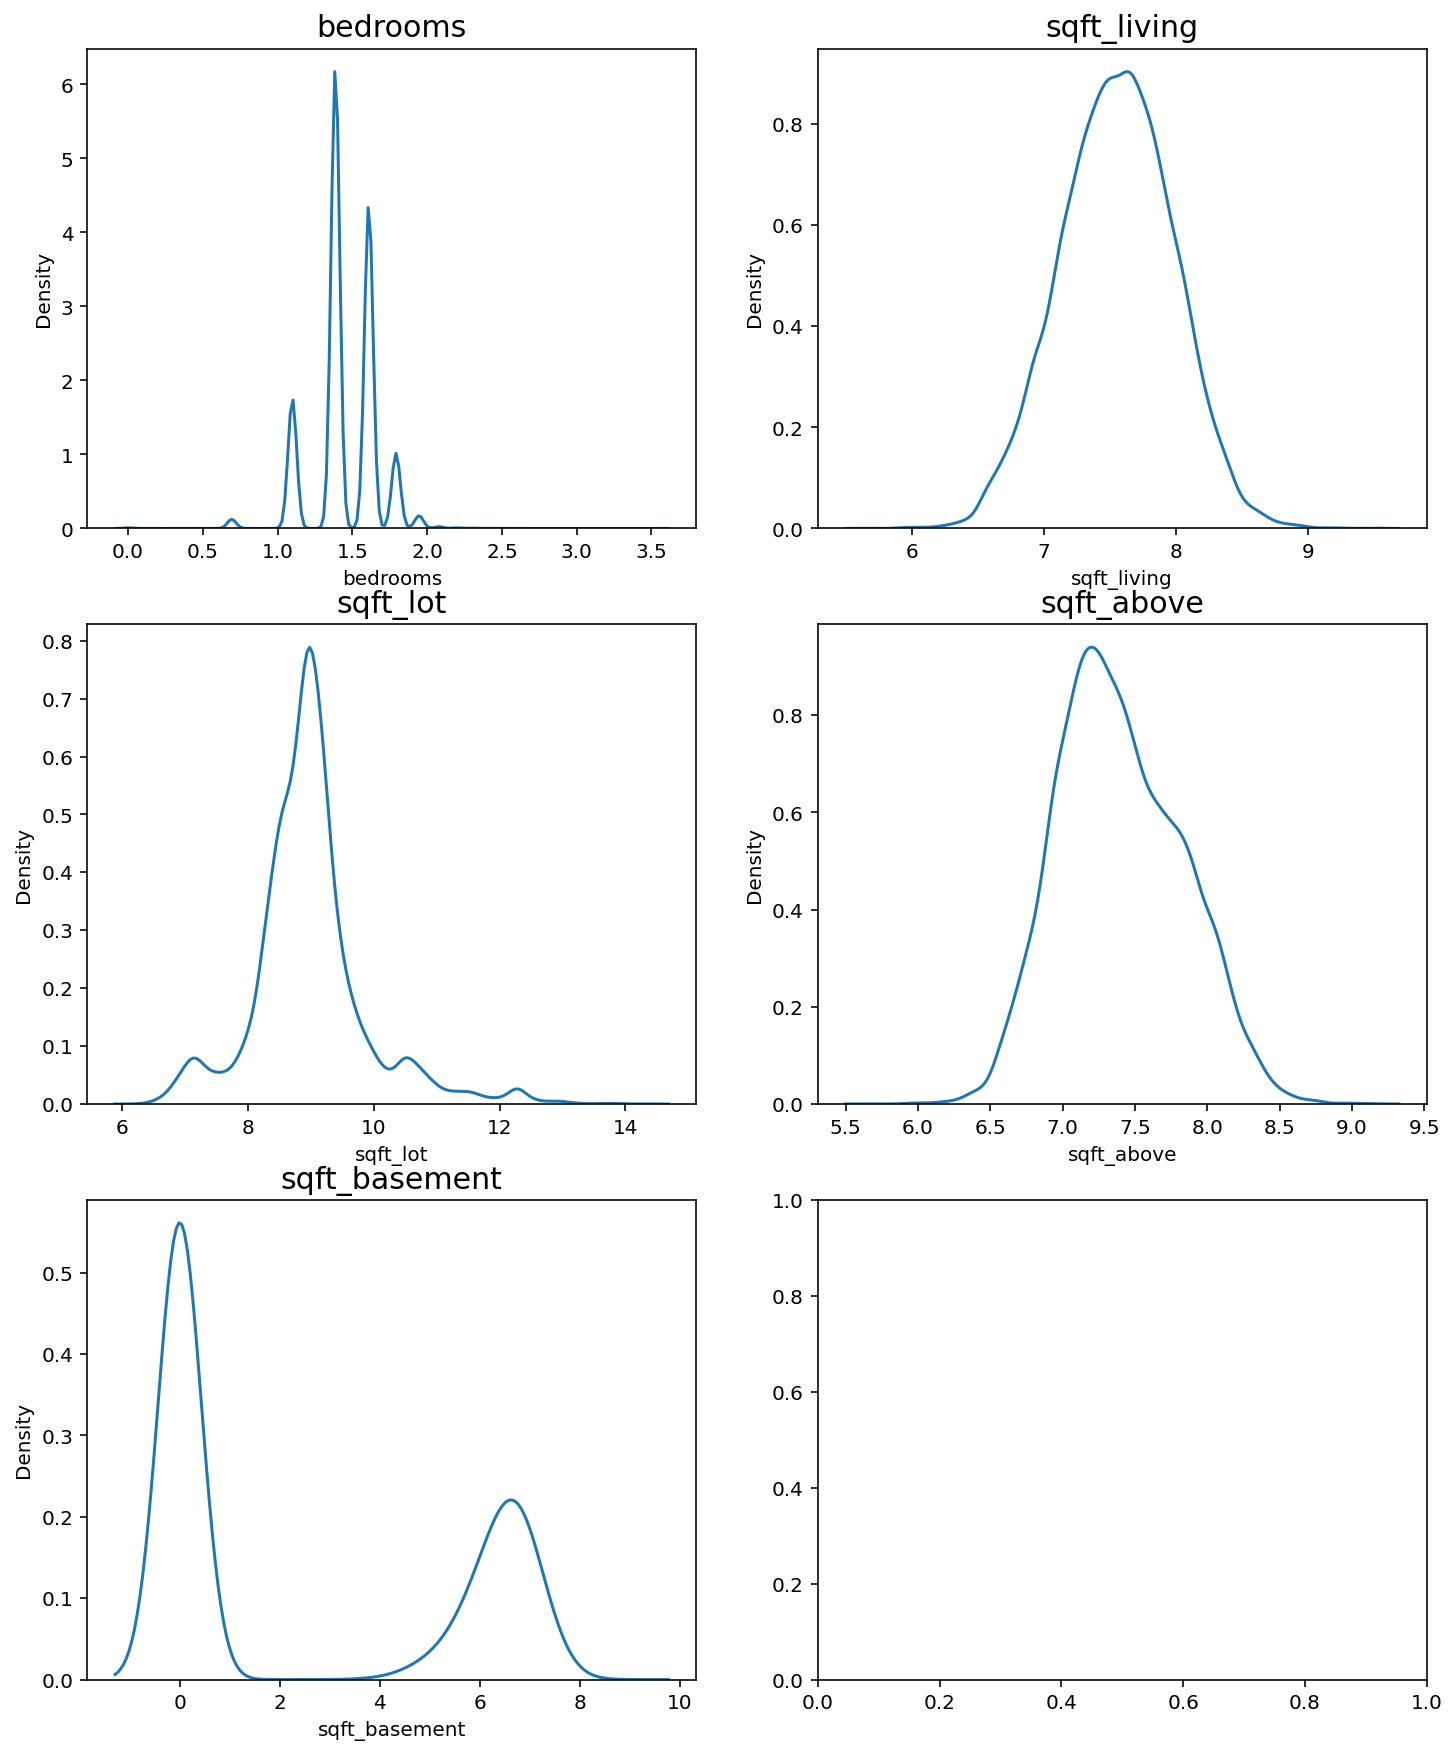

In [55]:
#다시 한 번 그래프를 그려 치우친 분포가 고쳐졌나 확인
fig, ax = plt.subplots(3, 2, figsize=(12, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

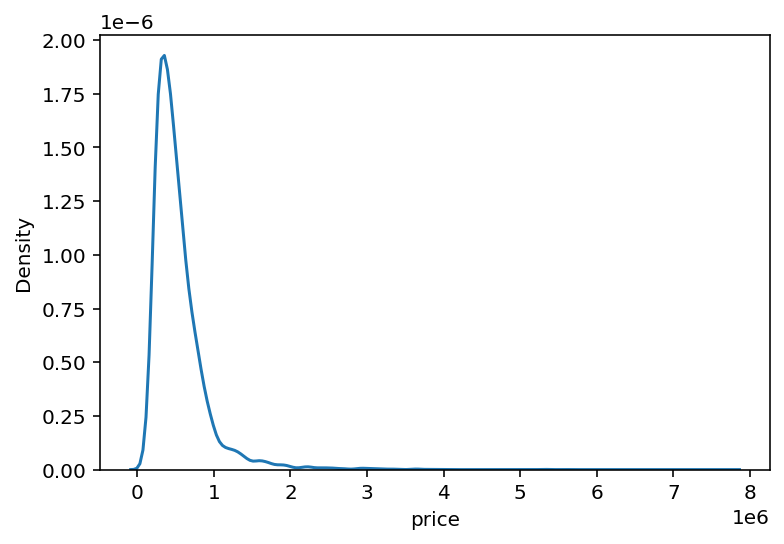

In [56]:
sns.kdeplot(y)
plt.show()

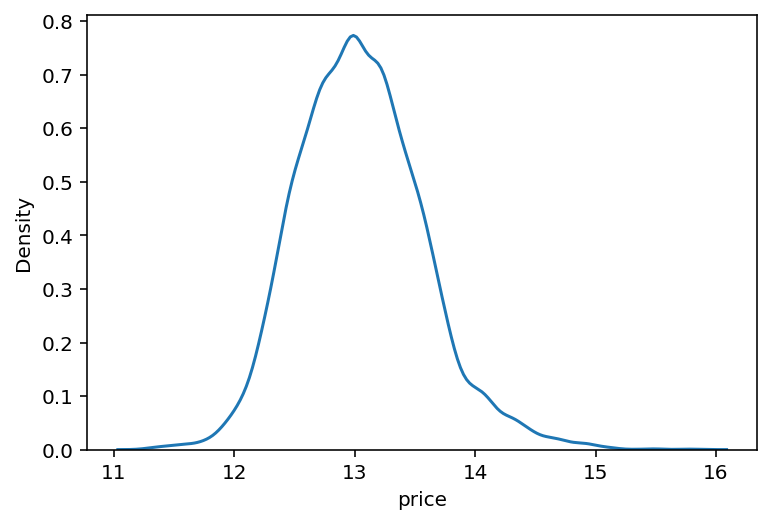

In [57]:
#치우쳤으니, 로그변환

y_log = np.log1p(y)

sns.kdeplot(y_log)
plt.show()

In [58]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

#아까 떼어놓기 전 그 크기와 같다.
print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


## 2. 모델 설계하기          

- 앙상블 기법 중 가장 기본적인 보팅(Voting), 에버리징(Averaging)     


### 우리는 여기서, gboost, xgboost, lightgbm의 세 가지 모델을 활용

In [59]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

print("모델 세팅 완료!")

모델 세팅 완료!


In [60]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
                                                  kf=kfold))
print('교차검증 준비 완료!')

교차검증 준비 완료!


In [61]:
get_cv_score(models)

Model GradientBoosting CV score : 0.8597
[05:26:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:26:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:26:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:26:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:26:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model XGBoost CV score : 0.8624
Model LightGBM CV score : 0.8819


In [62]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

print('설정 완료')

설정 완료


In [63]:
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

[05:26:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
6468


array([ 562566.39221578,  389660.68147617, 1340643.45409443, ...,
        438058.69137012,  345498.01852609,  414241.23776683])

In [64]:
#submission_file의 형태를 확인해보자.

In [65]:
file_path = "/content/drive/MyDrive/Colab Notebooks/data"
submission_path = join(file_path, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [66]:
#위의 submission파일의 구성에 맞게, id와 price로 구성된 데이터 프레임 제작

result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15035,5.625664e+05
1,15036,3.896607e+05
2,15037,1.340643e+06
3,15038,3.317573e+05
4,15039,2.966855e+05


In [67]:
#이 코드로, 만들어진 서브미션 파일을 저장
my_submission_path = join(file_path, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/content/drive/MyDrive/Colab Notebooks/data/submission.csv


## 챕터 2, 하이퍼 파라미터 튜닝하기

- 파라미터(모델 파라미터) : 모델이 학습하며 점차 최적화되는, 그리고 '최적화 되어야 하는' 파라미터 ex)선형 파라미터의 'W'(가중치)       
- 하이퍼 파라미터 : 모델이 학습을 하기 위해 사전에 사람이 직접 입력하는 파라미터 ex) epoch, 학습률 등       

---  

####이전과는 다르게 데이터를 준비

In [69]:
#데이터를 가져옵니다.
file_path = "/content/drive/MyDrive/Colab Notebooks/data"
train_path = join(file_path, 'train.csv')
test_path = join(file_path, 'test.csv')

print("트레인 패스는 여기에 :" , train_path)
print("테스트 패스는 여기에 : ", test_path)

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

트레인 패스는 여기에 : /content/drive/MyDrive/Colab Notebooks/data/train.csv
테스트 패스는 여기에 :  /content/drive/MyDrive/Colab Notebooks/data/test.csv


In [70]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [71]:
#data에 int와 char가 섞여있으므로, 전처리를 해준다. 
#단, 6자리만 일방적으로 남긴 것과 달리 int 정수형 데이터로 처리하여 예측을 위한 특성으로 활용할 수 있게끔 한다.
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [72]:
#price컬럼은, 이전과 같이 y변수에 넣어둔 후 train에서 삭제한다.
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [73]:
#id 컬럼은 굳이 필요하지 않으므로 삭제한다.
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [74]:
#test에 대해서도 동일하게 처리한 후, 타겟 데이터인 y를 확인한다.
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [75]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

- y의 값이 비교적 큰 편이며, 데이터의 분포도 확인해보자

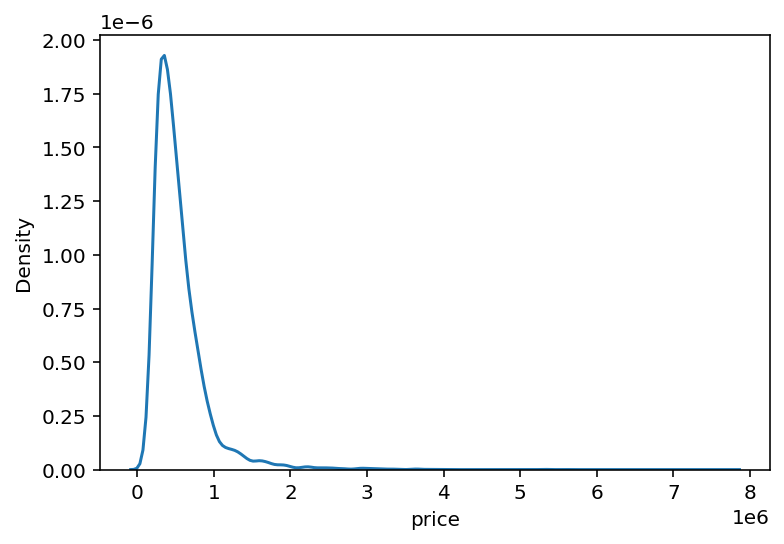

In [76]:
sns.kdeplot(y)
plt.show()

- y값이 치우쳐져 있으므로 np.log1p() 함수를 통해 로그 변환을 해주고, 
- 나중에 모델이 값을 예측한 후에 다시 np.exp1m()을 활용해서 되돌린다.    
- np.exp1m()은 np.log1p()과는 반대로 각 원소 x마다 exp(x)-1의 값을 반환해준다.

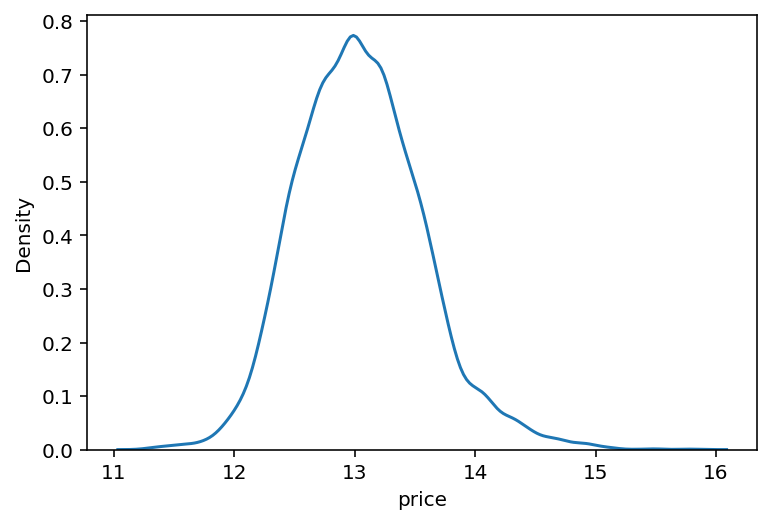

In [77]:
y = np.log1p(y)

sns.kdeplot(y)
plt.show()

In [78]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

### 2. 하이퍼 파라미터 실험을 위한 함수 제작          

##### RMSE 계산하기
- 데이터셋을 훈련 데이터셋과 검증 데이터셋으로 나누기 위한 train_test_split 함수 import
- RMSE 점수를 계산하기 위한 mean_squared_error 함수 가져오기

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print("임포트 완료!")

임포트 완료!


In [80]:
#아까 y값에 로그를 취했으므로, 이를 다시 되돌리기 위한 함수도 만들어준다.
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

print("완료")

완료


In [81]:
#다시 앙상블 할 모델을 가져옴
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [82]:
#항상 같은 값이 나오게 하기 위해 랜덤시드 = 2020으로 고정
random_state = 2020      

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [83]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [84]:
#각 모델별로 돌며 학습 및 예측
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

[05:28:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'GradientBoostingRegressor': 128360.19649691365,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125576.03932336495,
 'XGBRegressor': 131067.44622809246}

In [85]:
#위의 과정을 하나의 함수로 만듦
def get_scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

#### 다양한 하이퍼 파라미터를 탐색할 때, 최적의 조합을 찾으려면 어떻게 해야할까?    

- sklearn.model_selection 라이브러리 안에 있는 GridSearchCV클래스를 활용함

In [86]:
from sklearn.model_selection import GridSearchCV

print("완료")

완료


In [87]:
#xgboost관련 파라미터를 미리 넣어 준비
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

print("준비")

준비


In [88]:
#model은 lightgbm으로 선택
model = LGBMRegressor(random_state=random_state)

print('모델선택')

모델선택


In [89]:
#모델은 이렇게 파라미터를 입력하며 적용
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    5.9s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=2020,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_s

In [90]:
grid_model.cv_results_

{'mean_fit_time': array([0.2460824 , 0.32807431, 0.85395656, 1.36078987]),
 'mean_score_time': array([0.02084846, 0.02732682, 0.04452152, 0.0480967 ]),
 'mean_test_score': array([-0.07339447, -0.05502043, -0.02917734, -0.02702714]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'rank_test_score': array([4, 3, 2, 1], dtype=int32),
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': array([-0.07354904, -0.05546079, 

- 파라미터 조합은 params에, 테스트 점수는 mean_test_score에 저장되어 있음

In [91]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [92]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339447, -0.05502043, -0.02917734, -0.02702714])

In [93]:
results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,50,-0.073394
1,1,100,-0.055020
2,10,50,-0.029177
3,10,100,-0.027027


In [94]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [95]:
results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [96]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

#### 최댓값 찾기

In [97]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    3.0s finished


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


- 최적의 조합은 max_depth=10, n_estimators=100 ??



In [98]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.13580793, 13.08051399, 14.11202067, ..., 13.01592878,
       12.69894979, 12.96297768])

In [99]:
prediction = np.expm1(prediction)
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

In [102]:
data_dir = "/content/drive/MyDrive/Colab Notebooks/data"
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [103]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.067667e+05
1,15036,4.795061e+05
2,15037,1.345155e+06
3,15038,3.122579e+05
4,15039,3.338645e+05


In [104]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/content/drive/MyDrive/Colab Notebooks/data/submission_lgbm_RMSLE_0.164399.csv


In [107]:
#한번에 함수로 저장!
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = "/content/drive/MyDrive/Colab Notebooks/data"
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [108]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

/content/drive/MyDrive/Colab Notebooks/data/submission_lgbm_RMSLE_0.0168.csv saved!
